# Finetune ResNet50

With 1000 x 400 melspectrogra images with online data augmentation (Gaussian noise)

In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability

In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings

In [5]:
FINETUNED_MODEL = 'resnet50_augmented'

train_csv = '../../data/melspectrogram_train_dataset.csv'
test_csv = '../../data/melspectrogram_test_dataset.csv'
root_dir = '../../data/'

Custom dataset class for loading the precomputed tensors of the mel spectrogram images

In [6]:
from datasets.MelspectrogramDataset import MelSpectrogramDataset  

Define the training function

In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0
    
    # train mode
    model.train()
    
    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(trainloader), desc="training")
    
    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Update training loss
        train_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed
        
        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })
        
    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100
    
    return model, train_loss, train_accuracy

Define the testing/evaluation function

In [8]:
def test(model, testloader, criterion, device):
    test_loss = 0.0
    test_total = 0
    test_correct = 0
    
    # Switch to evaluation mode
    model.eval()
    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Update test loss
            test_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_loss = test_loss / len(testloader)
    test_accuracy = test_correct / test_total * 100
    
    return test_loss, test_accuracy

Define what happens in each epoch

In [9]:
def train_epochs(model, trainloader, testloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    best_accuracy =  0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()
        
        model, train_loss, train_accuracy = train(model, trainloader, criterion, optimizer, device)
        test_loss, test_accuracy = test(model, testloader, criterion, device)
        
        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(f'Test Loss: {test_loss} - Test Accuracy: {test_accuracy}')
        print()
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        # Check if current model is best performing using test_accuracy
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save(model.state_dict(), f'best_{FINETUNED_MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'test_losses': test_losses,
                'test_accuracies': test_accuracies,
            }
            torch.save(checkpoint, f'best_{FINETUNED_MODEL}_checkpoint.pt')
    
    return model, train_losses, train_accuracies, test_losses, test_accuracies

Plot the loss and accuracy graphs

In [10]:
def plot_loss(train_losses, test_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(test_losses)), test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_accuracy(train_accuracies, test_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)), train_accuracies, label='Training Accuracy')
    plt.plot(range(len(test_accuracies)), test_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Define the model

In [12]:
model = models.resnet50(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning

In [13]:
# Number of classes
num_classes = 9

# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify final fully connected layer according to number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
# print("Modified model")
# print(model)

# Unfreeze the final fully connected layer so it will be trained
for param in model.fc.parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Define a class to add Gaussian noise to the mel spectrogram images for online data augmentation

In [14]:
from data_augmentation.AddGaussianNoise import AddGaussianNoise

Define the learning rate, criterion, optimizer, transformations, and number of epochs

In [ ]:
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define train transformations, also the online data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the Mel spectrogram to 224x224, suitable for ResNet50
    transforms.ToTensor(),          # Convert to Tensor
    AddGaussianNoise(mean=0.0, std_range=(0.0, 0.1)
                     ),  # Online noise augmentation
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

# Define test transformations
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the Mel spectrogram to 224x224, suitable for ResNet50
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

epochs = 25

Execute the fine-tuning

Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.43it/s, Loss=1.3301588296890259, Elapsed=58.1666s, ETA=0.0000s] 


Epoch 1 completed in 81.6680s
Train Loss: 1.4958250112171414 - Train Accuracy: 41.53426066997764
Test Loss: 1.4444048139784071 - Test Accuracy: 44.19469726948952

Epoch 2/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.48it/s, Loss=1.1719624996185303, Elapsed=57.2032s, ETA=0.0000s] 


Epoch 2 completed in 80.7821s
Train Loss: 1.3540092217771313 - Train Accuracy: 46.74607728684778
Test Loss: 1.4391489799576576 - Test Accuracy: 42.010288880094976

Epoch 3/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.44it/s, Loss=1.3472951650619507, Elapsed=57.2642s, ETA=0.0000s] 


Epoch 3 completed in 81.0613s
Train Loss: 1.3299386516402039 - Train Accuracy: 47.725518906191255
Test Loss: 1.4741836738104772 - Test Accuracy: 41.84408389394539

Epoch 4/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.52it/s, Loss=1.6072964668273926, Elapsed=56.9095s, ETA=0.0000s] 


Epoch 4 completed in 80.3254s
Train Loss: 1.309470655948301 - Train Accuracy: 48.89689150952729
Test Loss: 1.482222814752598 - Test Accuracy: 42.02611792639493

Epoch 5/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.51it/s, Loss=1.1721571683883667, Elapsed=56.7102s, ETA=0.0000s] 


Epoch 5 completed in 80.4542s
Train Loss: 1.2934096677393854 - Train Accuracy: 49.65867943568333
Test Loss: 1.3528490006321607 - Test Accuracy: 47.21013058963198

Epoch 6/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.49it/s, Loss=1.2857462167739868, Elapsed=57.4915s, ETA=0.0000s] 


Epoch 6 completed in 80.7402s
Train Loss: 1.2801324684408646 - Train Accuracy: 49.8624824393043
Test Loss: 1.3231190274460147 - Test Accuracy: 48.43688167787891

Epoch 7/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.51it/s, Loss=1.250684380531311, Elapsed=56.7105s, ETA=0.0000s]  


Epoch 7 completed in 79.8915s
Train Loss: 1.273146125938319 - Train Accuracy: 50.45806209066266
Test Loss: 1.4253819976190123 - Test Accuracy: 44.05223585278987

Epoch 8/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.53it/s, Loss=1.2212275266647339, Elapsed=56.6899s, ETA=0.0000s] 


Epoch 8 completed in 79.9624s
Train Loss: 1.2653821676592283 - Train Accuracy: 50.72518253230178
Test Loss: 1.3857215679053105 - Test Accuracy: 45.714285714285715

Epoch 9/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.53it/s, Loss=1.227155327796936, Elapsed=56.6429s, ETA=0.0000s]  


Epoch 9 completed in 79.8240s
Train Loss: 1.2602730293817157 - Train Accuracy: 50.970537604622166
Test Loss: 1.3030532237255212 - Test Accuracy: 49.53700039572615

Epoch 10/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.52it/s, Loss=1.238430142402649, Elapsed=56.6941s, ETA=0.0000s]  


Epoch 10 completed in 79.9586s
Train Loss: 1.252633003947101 - Train Accuracy: 51.4513543995726
Test Loss: 1.320304472037036 - Test Accuracy: 49.32330827067669

Epoch 11/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.50it/s, Loss=1.3218327760696411, Elapsed=56.8192s, ETA=0.0000s] 


Epoch 11 completed in 80.2500s
Train Loss: 1.2488844717605205 - Train Accuracy: 51.34054888304082
Test Loss: 1.269096315509141 - Test Accuracy: 50.4392560348239

Epoch 12/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.54it/s, Loss=1.0991101264953613, Elapsed=56.6574s, ETA=0.0000s] 


Epoch 12 completed in 79.8543s
Train Loss: 1.239284321024448 - Train Accuracy: 51.6413067136271
Test Loss: 1.3514659392713295 - Test Accuracy: 47.54254056193115

Epoch 13/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.49it/s, Loss=1.3295787572860718, Elapsed=56.9052s, ETA=0.0000s] 


Epoch 13 completed in 80.1902s
Train Loss: 1.2409808667400215 - Train Accuracy: 51.62349868418449
Test Loss: 1.291401161087884 - Test Accuracy: 49.38662445587653

Epoch 14/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.50it/s, Loss=1.3162754774093628, Elapsed=56.8564s, ETA=0.0000s] 


Epoch 14 completed in 80.1690s
Train Loss: 1.2213204952734935 - Train Accuracy: 52.38924395021667
Test Loss: 1.2983684527753578 - Test Accuracy: 49.98021369212505

Epoch 15/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.47it/s, Loss=1.1048779487609863, Elapsed=56.9698s, ETA=0.0000s] 


Epoch 15 completed in 80.1935s
Train Loss: 1.2228133892711204 - Train Accuracy: 52.448604048358696
Test Loss: 1.3222559184739084 - Test Accuracy: 48.97506925207756

Epoch 16/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.50it/s, Loss=1.155824065208435, Elapsed=56.8933s, ETA=0.0000s]  


Epoch 16 completed in 80.0898s
Train Loss: 1.2197085286997542 - Train Accuracy: 52.488177447120044
Test Loss: 1.3085410908015087 - Test Accuracy: 49.33913731697665

Epoch 17/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.54it/s, Loss=1.140395998954773, Elapsed=56.5755s, ETA=0.0000s]  


Epoch 17 completed in 79.9225s
Train Loss: 1.2229082887685752 - Train Accuracy: 52.34769188151724
Test Loss: 1.2446755435731676 - Test Accuracy: 51.61851998417095

Epoch 18/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.52it/s, Loss=1.1042357683181763, Elapsed=56.6640s, ETA=0.0000s] 


Epoch 18 completed in 79.8108s
Train Loss: 1.216394239437731 - Train Accuracy: 52.77310591820179
Test Loss: 1.2547335769190933 - Test Accuracy: 51.26236644242185

Epoch 19/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.47it/s, Loss=1.1465507745742798, Elapsed=56.9696s, ETA=0.0000s] 


Epoch 19 completed in 80.2759s
Train Loss: 1.2105243257329434 - Train Accuracy: 53.00065296107957
Test Loss: 1.2821834400446728 - Test Accuracy: 49.149188761377125

Epoch 20/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.53it/s, Loss=1.0231139659881592, Elapsed=56.7230s, ETA=0.0000s] 


Epoch 20 completed in 79.8965s
Train Loss: 1.210291629350638 - Train Accuracy: 53.0224183303983
Test Loss: 1.2647477015100344 - Test Accuracy: 50.56588840522358

Epoch 21/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.52it/s, Loss=1.2114287614822388, Elapsed=56.5894s, ETA=0.0000s] 


Epoch 21 completed in 79.7939s
Train Loss: 1.19860452202302 - Train Accuracy: 53.534893844357825
Test Loss: 1.2510797279049652 - Test Accuracy: 52.06173328056985

Epoch 22/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.50it/s, Loss=1.357969880104065, Elapsed=56.7623s, ETA=0.0000s]  


Epoch 22 completed in 79.9419s
Train Loss: 1.202193321457392 - Train Accuracy: 53.483448425968064
Test Loss: 1.3621404411816838 - Test Accuracy: 47.930352196280175

Epoch 23/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.52it/s, Loss=1.1692242622375488, Elapsed=56.8312s, ETA=0.0000s] 


Epoch 23 completed in 80.0401s
Train Loss: 1.2024424290355247 - Train Accuracy: 53.333069510674925
Test Loss: 1.293339906316815 - Test Accuracy: 50.4788286505738

Epoch 24/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.51it/s, Loss=1.2160054445266724, Elapsed=56.7067s, ETA=0.0000s] 


Epoch 24 completed in 79.8309s
Train Loss: 1.2022483345828479 - Train Accuracy: 53.327133500860725
Test Loss: 1.3472504122088653 - Test Accuracy: 46.877720617332805

Epoch 25/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.53it/s, Loss=1.280570387840271, Elapsed=56.6280s, ETA=0.0000s]  


Epoch 25 completed in 79.8317s
Train Loss: 1.194842288011237 - Train Accuracy: 53.69714477927937
Test Loss: 1.2492705222332117 - Test Accuracy: 52.00633161851999



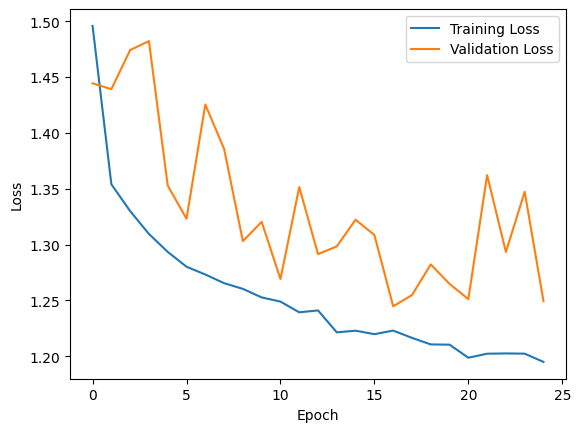

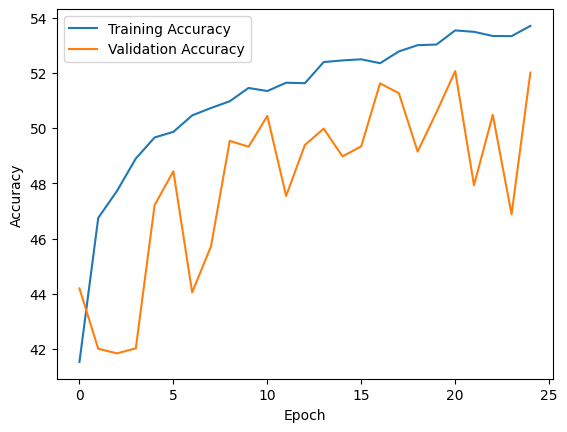

In [16]:
trainset = MelSpectrogramDataset(csv_file=train_csv, root_dir=root_dir, transform=train_transform)
testset = MelSpectrogramDataset(csv_file=test_csv, root_dir=root_dir, transform=test_transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, test_losses, test_accuracies = train_epochs(model, trainloader, testloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{FINETUNED_MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, test_losses)
plot_accuracy(train_accuracies, test_accuracies)

Plot confusion matrix

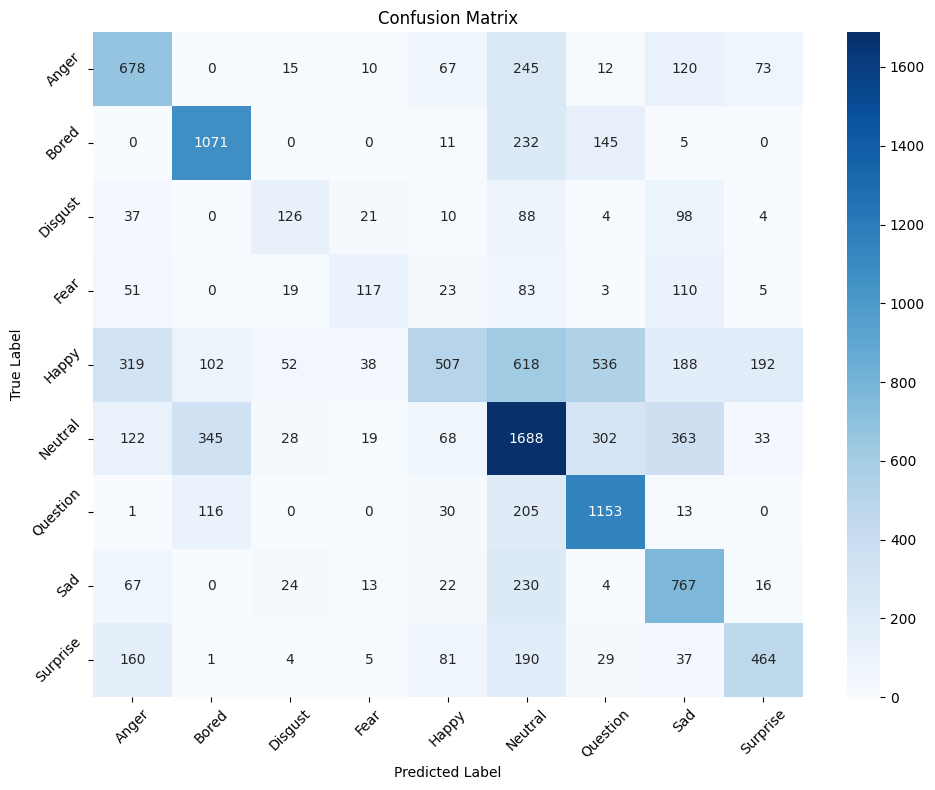

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create figure and axes
    plt.figure(figsize=(10, 8))
    
    # Create heatmap
    sns.heatmap(cm, 
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues', # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())
    
    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    
    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# To use this function, collect predictions and true labels during testing
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plot the confusion matrix
plot_confusion_matrix(all_labels, all_preds)